Goal: Save any interesting quantity to pickle

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from matplotlib_venn import venn2, venn3
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/analysis1_preliminaries/correlation_clustering.py'>

### Directories

In [3]:
# HiC information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [4]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directory of TF data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
# Directory of TCR/BCR data
dir_tcr = '/home/louiscam/projects/gpcr/data/tcr_data/'
dir_bcr = '/home/louiscam/projects/gpcr/data/bcr_data/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

# Load data

### Load  activity data

In [5]:
# Active/inactive loci
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci = pickle.load(f)
with open(saving_dir+'active_adhesome_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'inactive_adhesome_loci.pkl', 'rb') as f:
    inactive_adhesome_loci = pickle.load(f)

In [6]:
# Active/inactive genes
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)

### Load location data

In [7]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

### Load adhesome data

In [8]:
# Adhesome data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)
adhesome_chr_loci, missing_adhesome = lu.annotate_genes(df_components[['geneSymbol']], df_loc, resol)
adhesome_chr_loci['active'] = adhesome_chr_loci['gene'].isin(active_adhesome_genes)
all_adhesome_genes = df_components['geneSymbol'].unique()
# with open(saving_dir+'adhesome_chr_loci.pkl', 'wb') as f:
#     pickle.dump(adhesome_chr_loci, f)

### Load TF data

In [9]:
# All TF data
tftarget_df = pd.read_csv(dir_htftarget+'tftarget_full_processed.csv', 
                          sep='\t', index_col=0, header=0, low_memory=False)

In [10]:
len(tftarget_df.drop_duplicates(['tf', 'target_gene', 'cell_line', 'cell_type', 'tissue']))

5896536

In [11]:
len(tftarget_df['tf'].unique())

333

In [12]:
len(tftarget_df['target_gene'].unique())

55714

In [13]:
tftarget_df

,tf,target_gene,target_id,target_synonym,dataset_id,cell_line,cell_type,fibroblast,tissue,disease,condition,project,samples,control,source
0,EP300,NADK,ENSG00000008130,['dJ283E3.1'],913,GM12878,lymphoblastoid cell,False,blood,epstein-barr virus transformed,other,['GSE31477'],['GSM935294'],['GSM935390'],ENCODE
1,EP300,SLC2A5,ENSG00000142583,"['GLUT-5', 'GLUT5']",913,GM12878,lymphoblastoid cell,False,blood,epstein-barr virus transformed,other,['GSE31477'],['GSM935294'],['GSM935390'],ENCODE
2,EP300,SCARNA16,ENSG00000252404,[],913,GM12878,lymphoblastoid cell,False,blood,epstein-barr virus transformed,other,['GSE31477'],['GSM935294'],['GSM935390'],ENCODE
3,EP300,SZRD1,ENSG00000055070,['C1orf144'],913,GM12878,lymphoblastoid cell,False,blood,epstein-barr virus transformed,other,['GSE31477'],['GSM935294'],['GSM935390'],ENCODE
4,EP300,RP11-430L17.1,ENSG00000226457,[],913,GM12878,lymphoblastoid cell,False,blood,epstein-barr virus transformed,other,['GSE31477'],['GSM935294'],['GSM935390'],ENCODE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9022598,YY1,RP11-298I3.3,ENSG00000280129,[],5278,Jurkat,acute t cell leukemia cell,False,blood,acute t cell leukemia,other,['GSE99518'],['GSM2773998'],['GSM2773999'],NCBI
9022599,YY1,RP3-523C21.3,ENSG00000280155,[],5278,Jurkat,acute t cell leukemia cell,False,blood,acute t cell leukemia,other,['GSE99518'],['GSM2773998'],['GSM2773999'],NCBI
9022600,YY1,RP5-1180D12.1,ENSG00000280202,[],5278,Jurkat,acute t cell leukemia cell,False,blood,acute t cell leukemia,other,['GSE99518'],['GSM2773998'],['GSM2773999'],NCBI
9022601,YY1,RP11-972P1.7,ENSG00000280328,[],5278,Jurkat,acute t cell leukemia cell,False,blood,acute t cell leukemia,other,['GSE99518'],['GSM2773998'],['GSM2773999'],NCBI


In [14]:
# Select only TF-target pairs in lung fibroblasts
all_lung_cell_lines = tftarget_df[tftarget_df['tissue']=='lung']['cell_line'].unique()
lung_fibroblasts = ['IMR90', 'WI38', 'AG04450', 'HPF', 'NHLF', ]
tftarget_df_lungfibro = tftarget_df[tftarget_df['cell_line'].isin(lung_fibroblasts)]

In [15]:
# Include loci information
htargettf_df = tftarget_df_lungfibro[['tf','target_gene']]
htargettf_df.columns = ['geneSymbol', 'target']
lungTF_chr_loci, missing_TF = lu.annotate_genes(htargettf_df[['geneSymbol']].drop_duplicates(), df_loc, resol)
lungTF_chr_loci['active'] = lungTF_chr_loci['gene'].isin(active_genes)

### Load TCR data
- https://www.wikipathways.org/index.php/Pathway:WP69
- http://www.netpath.org/netslim/tcr_pathway.html

In [16]:
# TCR data
tcr_df = pd.read_csv(dir_tcr+'TCR.csv', header=0, index_col=None)
print('Total number of TCR intrinsic and associated components = '+str(len(tcr_df)))

Total number of TCR intrinsic and associated components = 92


### Load BCR data
- https://www.wikipathways.org/index.php/Pathway:WP23

In [17]:
# BCR data
bcr_df = pd.read_csv(dir_bcr+'BCR.csv', header=0, index_col=None, sep='\t')
print('Total number of BCR intrinsic and associated components = '+str(len(bcr_df)))

Total number of BCR intrinsic and associated components = 103


### Load genes related to mechanoregulation

In [18]:
# Proteins of interest
with open(dir_proteins+'mechanoreg_proteins.pkl', 'rb') as f:
    proteins_df = pickle.load(f)
proteins_chr_loci, missing_prot = lu.annotate_genes(proteins_df, df_loc, resol)
proteins_chr_loci['active'] = proteins_chr_loci['gene'].isin(active_genes)

In [19]:
# Mechanoreg protein to family
prot2fam = {proteins_df.iloc[i,0]: proteins_df.iloc[i,1] for i in range(len(proteins_df))}

# Define useful quantities

### Gene to chromosome dictionary

In [20]:
# Build dictionary matching each gene to its corresponding chromosome
gene2chrom = {g: df_loc[df_loc['geneSymbol']==g]['#chrom'].values[0] 
              for g in tqdm(df_loc['geneSymbol'].values)}
# with open(saving_dir+'gene2chrom.pkl', 'wb') as f:
#     pickle.dump(gene2chrom, f)

100%|██████████| 25959/25959 [00:41<00:00, 621.35it/s]


### Map from genes to locus

In [21]:
# Build dictionary matching each gene to its corresponding locus
gene2locus = {df_loc.iloc[i]['geneSymbol']: 
              ['chr_'+df_loc.iloc[i]['#chrom'].strip('chr')+'_loc_'+str(resol*x)
               for x in range(df_loc.iloc[i]['chromStart']//resol, df_loc.iloc[i]['chromEnd']//resol+1, 1)]
              for i in tqdm(range(df_loc.shape[0]))}
# with open(saving_dir+'gene2locus.pkl', 'wb') as f:
#     pickle.dump(gene2locus, f)

100%|██████████| 25959/25959 [00:10<00:00, 2418.07it/s]


In [22]:
# Build dictionary matching each locus to its corresponding genes
locus2gene = {}
for k, v in tqdm(gene2locus.items()):
    for vals in v:
        locus2gene[vals] = locus2gene.get(vals, []) + [k]
# with open(saving_dir+'locus2gene.pkl', 'wb') as f:
#     pickle.dump(locus2gene, f)

100%|██████████| 25959/25959 [00:00<00:00, 1112313.69it/s]


### Adhesome genes/loci

In [23]:
# All adhesome genes
all_adhesome_genes = np.unique(adhesome_chr_loci['gene'])
# with open(saving_dir+'all_adhesome_genes.pkl', 'wb') as f:
#     pickle.dump(all_adhesome_genes, f)

all_adhesome_loci = np.unique(adhesome_chr_loci['locus_id'])
# with open(saving_dir+'all_adhesome_loci.pkl', 'wb') as f:
#     pickle.dump(all_adhesome_loci, f)

In [24]:
# Adhesome gene2locus and locus2gene dictionaries
adhesome_gene2locus = {gene: adhesome_chr_loci[adhesome_chr_loci['gene']==gene]['locus_id'].values.astype(str)  
              for gene in np.unique(adhesome_chr_loci['gene'])}
# with open(saving_dir+'adhesome_gene2locus.pkl', 'wb') as f:
#     pickle.dump(adhesome_gene2locus, f)

adhesome_locus2gene = {locus: adhesome_chr_loci[adhesome_chr_loci['locus_id']==locus]['gene'].values.astype(str) 
              for locus in np.unique(adhesome_chr_loci['locus_id'])}
# with open(saving_dir+'adhesome_locus2gene.pkl', 'wb') as f:
#     pickle.dump(adhesome_locus2gene, f)

In [25]:
# Active adhesome gene2locus and locus2gene dictionaries
active_adhesome_gene2locus = {gene: adhesome_chr_loci[(adhesome_chr_loci['gene']==gene) &
                                                      (adhesome_chr_loci['active']==True)]['locus_id'].values.astype(str)  
              for gene in np.unique(adhesome_chr_loci['gene'])}
# with open(saving_dir+'active_adhesome_gene2locus.pkl', 'wb') as f:
#     pickle.dump(active_adhesome_gene2locus, f)

active_adhesome_locus2gene = {locus: adhesome_chr_loci[(adhesome_chr_loci['locus_id']==locus) &
                                                      (adhesome_chr_loci['active']==True)]['gene'].values.astype(str) 
              for locus in np.unique(adhesome_chr_loci['locus_id'])}
# with open(saving_dir+'active_adhesome_locus2gene.pkl', 'wb') as f:
#     pickle.dump(active_adhesome_locus2gene, f)

### All active lung TF genes/loci

In [20]:
# Merge TF and target information
lungTF_chr_loci1 = lungTF_chr_loci.copy()
lungTF_chr_loci1.columns = ['chrom', 'chrom_int', 'loci', 'tf', 'locus_id', 'active']
tf_target_df = tftarget_df_lungfibro.merge(lungTF_chr_loci1, on='tf')
tf_target_df = tf_target_df[['tf', 'chrom', 'chrom_int', 'loci', 'locus_id', 'active', 'target_gene']]
tf_target_df.columns = ['geneSymbol', 'chrom', 'chrom_int', 'loci', 'locus_id', 'active', 'target']
tf_target_df.head()

,geneSymbol,chrom,chrom_int,loci,locus_id,active,target
0,LMNB1,chr5,5,504,chr_5_loc_126000000,True,AGBL5-AS1
1,LMNB1,chr5,5,504,chr_5_loc_126000000,True,AGBL5
2,LMNB1,chr5,5,504,chr_5_loc_126000000,True,RP11-204L24.2
3,LMNB1,chr5,5,504,chr_5_loc_126000000,True,CLASP1
4,LMNB1,chr5,5,504,chr_5_loc_126000000,True,RNU4ATAC


In [21]:
# Select active TFs targeting active genes
active_tf_target_df = tf_target_df[(tf_target_df['geneSymbol'].isin(active_genes)) & 
                                   (tf_target_df['target'].isin(active_genes))]

active_lung_tf2target = {tf: set(active_tf_target_df[active_tf_target_df['geneSymbol']==tf]['target'].unique())
                        for tf in tqdm(active_tf_target_df['geneSymbol'].unique())}
# with open(saving_dir+'active_lung_tf2target.pkl', 'wb') as f:
#     pickle.dump(active_lung_tf2target, f)

active_lung_target2tf = {target: set(active_tf_target_df[active_tf_target_df['target']==target]['geneSymbol'].unique())
                        for target in active_tf_target_df['target'].unique()}
# with open(saving_dir+'active_lung_target2tf.pkl', 'wb') as f:
#     pickle.dump(active_lung_target2tf, f)

100%|██████████| 28/28 [00:00<00:00, 79.28it/s]


In [22]:
# Store active TFs targeting active genes
active_lung_tf_genes = tf_target_df[(tf_target_df['geneSymbol'].isin(active_genes)) & 
                                    (tf_target_df['target'].isin(active_genes))]['geneSymbol'].unique()
# with open(saving_dir+'active_lung_tf_genes.pkl', 'wb') as f:
#     pickle.dump(active_lung_tf_genes, f)

active_lung_tf_loci = tf_target_df[(tf_target_df['geneSymbol'].isin(active_genes)) & 
                                   (tf_target_df['target'].isin(active_genes))]['locus_id'].unique()
# with open(saving_dir+'active_lung_tf_loci.pkl', 'wb') as f:
#     pickle.dump(active_lung_tf_loci, f)

In [23]:
# Breakdown of TFs in normal lung fibroblasts
print('Number of TFs in normal lung fibroblasts cell lines = '+str(tftarget_df_lungfibro['tf'].nunique()))
print(tftarget_df_lungfibro['tf'].unique())
print('TFs in the different cell lines')
lungfibro_breadkdown_df = tftarget_df_lungfibro.drop_duplicates(['tf', 'cell_line'])
lungfibro_breadkdown_df = lungfibro_breadkdown_df.groupby(['cell_line'])['tf'].agg(list).reset_index()
lungfibro_breadkdown_df['n_tfs'] = [len(ls) 
                                    for ls in lungfibro_breadkdown_df['tf']]
lungfibro_breadkdown_df['n_active_tfs'] = [len(set(ls).intersection(set(active_genes))) 
                                           for ls in lungfibro_breadkdown_df['tf']]
print(lungfibro_breadkdown_df)
print('TFs in WI38 that are not in IMR90')
print(set(lungfibro_breadkdown_df[lungfibro_breadkdown_df['cell_line']=='WI38']['tf'].values[0])-
      set(lungfibro_breadkdown_df[lungfibro_breadkdown_df['cell_line']=='IMR90']['tf'].values[0]))


Number of TFs in normal lung fibroblasts cell lines = 31
['LMNB1' 'RBL2' 'MAFK' 'BRF2' 'CTCF' 'RB1' 'E2F7' 'CHD1' 'EP300' 'SUMO2'
 'UBE2I' 'PIAS4' 'SNAPC2' 'SUMO1' 'GTF2B' 'BRCA1' 'RFX5' 'BDP1' 'RCOR1'
 'SNAPC1' 'TP53' 'CEBPB' 'RAD21' 'POLR2A' 'RBL1' 'SNAPC5' 'SNAPC4' 'BRF1'
 'MXI1' 'MAZ' 'SPI1']
TFs in the different cell lines
  cell_line                                                 tf  n_tfs  \
0   AG04450                                             [CTCF]      1   
1       HPF                                             [CTCF]      1   
2     IMR90  [LMNB1, RBL2, MAFK, BRF2, RB1, E2F7, CHD1, EP3...     27   
3      NHLF                                             [CTCF]      1   
4      WI38                 [SUMO2, UBE2I, PIAS4, SUMO1, CTCF]      5   

   n_active_tfs  
0             1  
1             1  
2            24  
3             1  
4             5  
TFs in WI38 that are not in IMR90
{'SUMO2', 'SUMO1', 'UBE2I', 'PIAS4'}


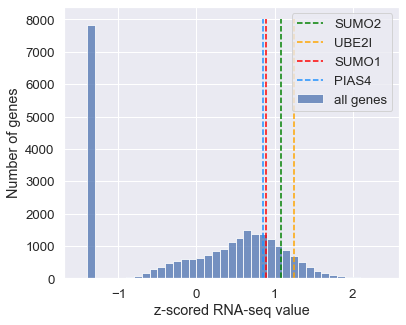

In [26]:
# Check whether 'SUMO2', 'UBE2I', 'SUMO1', 'PIAS4' are expressed in IMR90
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
df_select = df_all_norm.loc[['RNAseq'], :]
# Plot expression of genes compared to histogram of RNAseq of all genes
col_dict = {'SUMO2':'green', 'UBE2I':'orange', 'SUMO1':'red', 'PIAS4':'dodgerblue'}
sns.set(font_scale=1.2)
plt.figure(figsize=(6,5))
sns.histplot(df_all_norm.loc['RNAseq', :].values, bins=np.arange(-1.5, 2.5, 0.1),
         label='all genes')
for g in ['SUMO2', 'UBE2I', 'SUMO1', 'PIAS4']:
    plt.vlines(x=df_all_norm.loc['RNAseq', g], ymin=0, ymax=8000, 
               color=col_dict[g], linestyle='dashed', label=g)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('Number of genes')
plt.legend(loc='upper right')
plt.show()

### Lung TF genes/loci targeting adhesome

In [26]:
# Select all lung fibroblast TFs targeting active genes
all_lung_adhesome_tf_genes = tftarget_df_lungfibro[tftarget_df_lungfibro['target_gene'].isin(active_adhesome_genes)]
all_lung_adhesome_tf_genes = all_lung_adhesome_tf_genes['tf'].unique()
# with open(saving_dir+'all_lung_adhesome_tf_genes.pkl', 'wb') as f:
#     pickle.dump(all_lung_adhesome_tf_genes, f)

In [27]:
# Active TF genes targeting active adhesome
active_lung_adhesome_tf_genes = tf_target_df[(tf_target_df['target'].isin(active_adhesome_genes)) &
                                             (tf_target_df['geneSymbol'].isin(active_genes))]['geneSymbol'].unique()
# with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'wb') as f:
#     pickle.dump(active_lung_adhesome_tf_genes, f)

active_lung_adhesome_tf_loci = tf_target_df[(tf_target_df['target'].isin(active_adhesome_genes)) &
                                            (tf_target_df['geneSymbol'].isin(active_genes))]['locus_id'].unique()
# with open(saving_dir+'active_lung_adhesome_tf_loci.pkl', 'wb') as f:
#     pickle.dump(active_lung_adhesome_tf_loci, f)

In [28]:
# Lung fibroblast TFs that are not active or do not target active adhesome genes
set(np.sort(tf_target_df['geneSymbol'].unique()))-set(np.sort(active_lung_adhesome_tf_genes))

{'CHD1', 'SNAPC1', 'SNAPC4', 'SNAPC5', 'SPI1'}

In [29]:
# Dictionary tf2target and target2tf
active_adhesome_tf_target_df = tf_target_df[(tf_target_df['geneSymbol'].isin(active_lung_adhesome_tf_genes)) &
                                            (tf_target_df['target'].isin(active_adhesome_genes))]

adhesome_active_lung_tf2target = {tf: active_adhesome_tf_target_df[active_adhesome_tf_target_df['geneSymbol']==tf]['target'].unique() 
                                  for tf in active_lung_adhesome_tf_genes}
# with open(saving_dir+'adhesome_active_lung_tf2target.pkl', 'wb') as f:
#     pickle.dump(adhesome_active_lung_tf2target, f)

adhesome_active_lung_target2tf = {target: active_adhesome_tf_target_df[active_adhesome_tf_target_df['target']==target]['geneSymbol'].unique() 
                                  for target in active_adhesome_tf_target_df['target'].unique()}
# with open(saving_dir+'adhesome_active_lung_target2tf.pkl', 'wb') as f:
#     pickle.dump(adhesome_active_lung_target2tf, f)

### TCR genes/loci

In [30]:
# Select active/inactive TCR genes and loci
tcr_chr_loci, missing_tcr = lu.annotate_genes(tcr_df[['geneSymbol']], df_loc, resol)
tcr_chr_loci['gene_active'] = tcr_chr_loci['gene'].isin(active_genes)
tcr_chr_loci['locus_active'] = tcr_chr_loci['locus_id'].isin(all_active_loci)
tcr_genes = tcr_chr_loci['gene'].unique()
tcr_loci = tcr_chr_loci['locus_id'].unique()
active_tcr_genes = tcr_chr_loci[tcr_chr_loci['gene_active']==True]['gene'].unique()
active_tcr_loci = tcr_chr_loci[tcr_chr_loci['locus_active']==True]['locus_id'].unique()
inactive_tcr_genes = tcr_chr_loci[tcr_chr_loci['gene_active']==False]['gene'].unique()
inactive_tcr_loci = tcr_chr_loci[tcr_chr_loci['locus_active']==False]['locus_id'].unique()
print('TCR genes missing from location data = '+str(missing_tcr))
print('Total number of TCR genes = '+str(len(tcr_genes)))
print('Total number of TCR loci = '+str(len(tcr_loci)))
print('Total number of active TCR genes = '+str(len(active_tcr_genes)))
print('Total number of active TCR loci = '+str(len(active_tcr_loci)))

TCR genes missing from location data = ['IKBKG', 'WAS']
Total number of TCR genes = 90
Total number of TCR loci = 113
Total number of active TCR genes = 63
Total number of active TCR loci = 103


In [31]:
# Save to pickle
# with open(saving_dir+'tcr_chr_loci.pkl', 'wb') as f:
#     pickle.dump(tcr_chr_loci, f)
# with open(saving_dir+'tcr_genes.pkl', 'wb') as f:
#     pickle.dump(tcr_genes, f)
# with open(saving_dir+'tcr_loci.pkl', 'wb') as f:
#     pickle.dump(tcr_loci, f)
# with open(saving_dir+'active_tcr_genes.pkl', 'wb') as f:
#     pickle.dump(active_tcr_genes, f)
# with open(saving_dir+'inactive_tcr_genes.pkl', 'wb') as f:
#     pickle.dump(inactive_tcr_genes, f)
# with open(saving_dir+'active_tcr_loci.pkl', 'wb') as f:
#     pickle.dump(active_tcr_loci, f)
# with open(saving_dir+'inactive_tcr_loci.pkl', 'wb') as f:
#     pickle.dump(inactive_tcr_loci, f)

### BCR genes/loci

In [24]:
# Select active/inactive BCR genes and loci
bcr_chr_loci, missing_bcr = lu.annotate_genes(bcr_df[['geneSymbol']], df_loc, resol)
bcr_chr_loci['gene_active'] = bcr_chr_loci['gene'].isin(active_genes)
bcr_chr_loci['locus_active'] = bcr_chr_loci['locus_id'].isin(all_active_loci)
bcr_genes = bcr_chr_loci['gene'].unique()
bcr_loci = bcr_chr_loci['locus_id'].unique()
active_bcr_genes = bcr_chr_loci[bcr_chr_loci['gene_active']==True]['gene'].unique()
active_bcr_loci = bcr_chr_loci[bcr_chr_loci['locus_active']==True]['locus_id'].unique()
inactive_bcr_genes = bcr_chr_loci[bcr_chr_loci['gene_active']==False]['gene'].unique()
inactive_bcr_loci = bcr_chr_loci[bcr_chr_loci['locus_active']==False]['locus_id'].unique()
print('BCR genes missing from location data = '+str(missing_bcr))
print('Total number of BCR genes = '+str(len(bcr_genes)))
print('Total number of BCR loci = '+str(len(bcr_loci)))
print('Total number of active BCR genes = '+str(len(active_bcr_genes)))
print('Total number of active BCR loci = '+str(len(active_bcr_loci)))

BCR genes missing from location data = ['PI-4,5-P2', 'PI-4-P', 'ELK1', 'DAG', 'IKBKG', 'IP3', 'CD45', 'PDPK2', 'PRKCB1', 'BTK']
Total number of BCR genes = 93
Total number of BCR loci = 118
Total number of active BCR genes = 72
Total number of active BCR loci = 112


In [25]:
# Save to pickle
# with open(saving_dir+'bcr_chr_loci.pkl', 'wb') as f:
#     pickle.dump(bcr_chr_loci, f)
# with open(saving_dir+'bcr_genes.pkl', 'wb') as f:
#     pickle.dump(bcr_genes, f)
# with open(saving_dir+'bcr_loci.pkl', 'wb') as f:
#     pickle.dump(bcr_loci, f)
# with open(saving_dir+'active_bcr_genes.pkl', 'wb') as f:
#     pickle.dump(active_bcr_genes, f)
# with open(saving_dir+'inactive_bcr_genes.pkl', 'wb') as f:
#     pickle.dump(inactive_bcr_genes, f)
# with open(saving_dir+'active_bcr_loci.pkl', 'wb') as f:
#     pickle.dump(active_bcr_loci, f)
# with open(saving_dir+'inactive_bcr_loci.pkl', 'wb') as f:
#     pickle.dump(inactive_bcr_loci, f)

# Jointly consider active adhesome genes, and active adhesome lung TFs

In [32]:
# Gene and locus dataframe for acive adhesome genes and adhesome TFs
adh_and_tf_chr_loci = pd.concat([adhesome_chr_loci[adhesome_chr_loci['active']],
                                 lungTF_chr_loci[lungTF_chr_loci['gene'].isin(active_lung_adhesome_tf_genes)]], 
                                 axis=0)
# with open(saving_dir+'adh_and_tf_chr_loci.pkl', 'wb') as f:
#     pickle.dump(adh_and_tf_chr_loci, f)

In [33]:
# gene2locus and locus2gene dictionaries for adhesome+adhesome TFs
adh_and_tf_gene2locus = {gene: adh_and_tf_chr_loci[adh_and_tf_chr_loci['gene']==gene]['locus_id'].values.astype(str)  
              for gene in np.unique(adh_and_tf_chr_loci['gene'])}
# with open(saving_dir+'adh_and_tf_gene2locus.pkl', 'wb') as f:
#     pickle.dump(adh_and_tf_gene2locus, f)

adh_and_tf_locus2gene = {locus: adh_and_tf_chr_loci[adh_and_tf_chr_loci['locus_id']==locus]['gene'].values.astype(str) 
              for locus in np.unique(adh_and_tf_chr_loci['locus_id'])}
# with open(saving_dir+'adh_and_tf_locus2gene.pkl', 'wb') as f:
#     pickle.dump(adh_and_tf_locus2gene, f)

# Jointly consider active adhesome genes, lung TFs and mechanoreg proteins

In [34]:
# Active adhesome genes
act_adhesome_chr_loci = adhesome_chr_loci[adhesome_chr_loci['active']==True]
# with open(saving_dir+'act_adhesome_chr_loci.pkl', 'wb') as f:
#     pickle.dump(act_adhesome_chr_loci, f)

# Active lung TFs
act_lung_TF_chr_loci = lungTF_chr_loci1[lungTF_chr_loci1['tf'].isin(active_lung_tf_genes)]
act_lung_TF_chr_loci.columns = ['chrom', 'chrom_int', 'loci', 'gene', 'locus_id', 'active']
# with open(saving_dir+'act_lung_TF_chr_loci.pkl', 'wb') as f:
#     pickle.dump(act_lung_TF_chr_loci, f)

# Active mechanoreg proteins
act_proteins_chr_loci = proteins_chr_loci[proteins_chr_loci['active']==True]
# with open(saving_dir+'act_proteins_chr_loci.pkl', 'wb') as f:
#     pickle.dump(act_proteins_chr_loci, f)

In [35]:
# Joint annotated dataframe
joint_chr_loci = pd.concat([act_adhesome_chr_loci,act_lung_TF_chr_loci,act_proteins_chr_loci], axis=0)
# with open(saving_dir+'joint_chr_loci.pkl', 'wb') as f:
#     pickle.dump(joint_chr_loci, f)

joint_loci = np.unique(joint_chr_loci['locus_id'])
# with open(saving_dir+'joint_loci.pkl', 'wb') as f:
#     pickle.dump(joint_loci, f)

joint_genes = np.unique(joint_chr_loci['gene'])
# with open(saving_dir+'joint_genes.pkl', 'wb') as f:
#     pickle.dump(joint_genes, f)

In [36]:
# gene2locus and locus2gene dictionaries
selected_gene2locus = {gene: joint_chr_loci[joint_chr_loci['gene']==gene]['locus_id'].values.astype(str)  
                       for gene in np.unique(joint_chr_loci['gene'])}
# with open(saving_dir+'selected_gene2locus.pkl', 'wb') as f:
#     pickle.dump(selected_gene2locus, f)

selected_locus2gene = {locus: joint_chr_loci[joint_chr_loci['locus_id']==locus]['gene'].values.astype(str) 
                       for locus in np.unique(joint_chr_loci['locus_id'])}
# with open(saving_dir+'selected_locus2gene.pkl', 'wb') as f:
#     pickle.dump(selected_locus2gene, f)

In [41]:
# Get HiC contact map
contacts_df = pd.DataFrame(0, index=joint_loci, columns=joint_loci)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in joint_loci if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in joint_loci if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df = contacts_df+contacts_df.T
# Save to pickle
# with open(saving_dir+f'contacts_df_{norm}.pkl', 'wb') as f:
#     pickle.dump(contacts_df, f)

100%|██████████| 231/231 [00:18<00:00, 12.79it/s]
